<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

# Состав команды
### Ячменьков Алексей:
#### задание 1,  задание 4, задание 5
#####
### Баранов Владислав:
#### Задание 2, задание 3
#####
### Аллабердин Богдан:
#### Задание 6


Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [12]:
import os
from pathlib import Path

import cv2
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image

In [13]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [18]:
!pip install wget

In [ ]:
!python -m wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!python -m wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip


Saved under images_evaluation.zip

Saved under images_background.zip


In [ ]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

In [3]:
wandb.init(project='homework', name='baseline')

wandb: Currently logged in as: tokomeir (educt). Use `wandb login --relogin` to force relogin


### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [14]:
def read_alphabets(alphabet_directory_path: str):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names 

    for character in os.listdir(alphabet_directory_path):
        character_path = os.path.join(alphabet_directory_path, character)
        if os.path.isdir(character_path) and 'rotated' not in character_path:
            for image in os.listdir(character_path):
                if image.endswith('.png'):
                    image_path = os.path.join(character_path, image)
                    
                    datax.append(image_path)
                    datay.append(character_path)
                    
                    original_image = Image.open(image_path)
                    
                    for degree in [90, 180, 270]:
                        rotated_character_path = character_path + f'_rotated_{degree}'
                        os.makedirs(rotated_character_path, exist_ok=True)
                        
                        rotated_image = original_image.rotate(degree)
                        rotated_image_path = os.path.join(rotated_character_path, image)
                        
                        rotated_image.save(rotated_image_path)
                        
                        datax.append(rotated_image_path)
                        datay.append(rotated_character_path)
  
    return np.array(datax), np.array(datay)

In [15]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None

    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [16]:
trainx, trainy = read_images('./images_background')

In [17]:
testx, testy = read_images('./images_evaluation')

In [18]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120,), (77120,), (52720,), (52720,))

## Create samples

In [22]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'targets': K,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [23]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['./images_background/Gujarati/character14_rotated_90'
 './images_background/Cyrillic/character14_rotated_90'
 './images_background/Korean/character33_rotated_180'
 './images_background/Japanese_(katakana)/character21_rotated_180'
 './images_background/Mkhedruli_(Georgian)/character27_rotated_180'
 './images_background/Latin/character07_rotated_270'
 './images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/character12_rotated_180'
 './images_background/Mkhedruli_(Georgian)/character17_rotated_180']


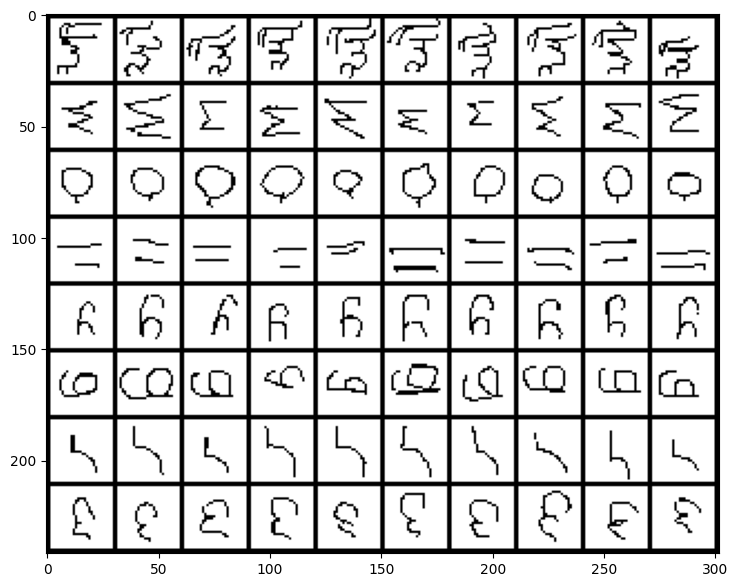

In [24]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])
print(sample_example['targets'])

In [25]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [26]:
def get_submodule(in_channels, out_channels, kernel_size = 3):
    padding = kernel_size // 2
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

def get_encoder(x_dim, hid_dim, z_dim):
    return nn.Sequential(
        get_submodule(x_dim, hid_dim),
        get_submodule(hid_dim, hid_dim),
        get_submodule(hid_dim, hid_dim),
        get_submodule(hid_dim, z_dim)
    )

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [27]:
class ProtoNet(nn.Module):
    def __init__(self, encoder, device='cuda'):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.device = device
        self.encoder = encoder.to(self.device)

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        sample_images = sample_images.to(self.device)
        sample_images = sample_images.view(n_way * (n_support + n_query), *sample_images.shape[-3:])

        # img2vec results
        vectors = self.encoder(sample_images).view(n_way, (n_support + n_query), -1)

        # центры тяжести класстеров классов
        prototypes = vectors[:, :n_support].mean(1)

        # ищем расстояния от каждого изображения из query до каждого центра тяжести
        queries = vectors[:, n_support:].contiguous().view(-1, vectors.shape[-1])
        query_dists = list()
        for query in queries:
            prototype_dists = torch.stack([torch.sqrt(torch.pow(query - prototype, 2).sum()) for prototype in prototypes])
            query_dists.append(prototype_dists)
        query_dists = torch.stack(query_dists)

        probabilities = F.log_softmax(-query_dists, dim=1).view(n_way, n_query, -1)

        _, y_hat = probabilities.max(2)

        losses = list()
        n_true_positive = 0
        for way in range(n_way):
            for query in range(n_query):
                losses.append(-probabilities[way][query][way])
                if y_hat[way][query] == way:
                    n_true_positive += 1
        loss_val = torch.stack(losses).mean()
        acc = n_true_positive / (n_way * n_query)

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc,
            'y_hat': y_hat
            }

In [28]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = get_encoder(kwargs['x_dim'][0], kwargs['hid_dim'], kwargs['z_dim'])

    return ProtoNet(encoder, kwargs['device'])

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [16]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    if wandb.run is not None:
        wandb.watch(model)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    train_losses = []
    train_acc = []
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        if wandb.run is not None:
            wandb.log({'Epoch': epoch + 1, 'Loss': round(epoch_loss, 4), 'Acc': round(epoch_acc, 4)})
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()
    torch.save(model.state_dict(), "new_model.pt")
    return train_losses, train_acc

In [17]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
    device='cuda'
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 3
epoch_size = 1000

In [18]:
from for_task6.show_train_res import plot_losses

In [19]:
%%time

loss, acc = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.1808 Acc: 0.9618


Epoch 2 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0600 Acc: 0.9838


Epoch 3 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0468 Acc: 0.9866
CPU times: total: 2h 57min 1s
Wall time: 2h 11min 22s


## Графики обучения ProtoNet

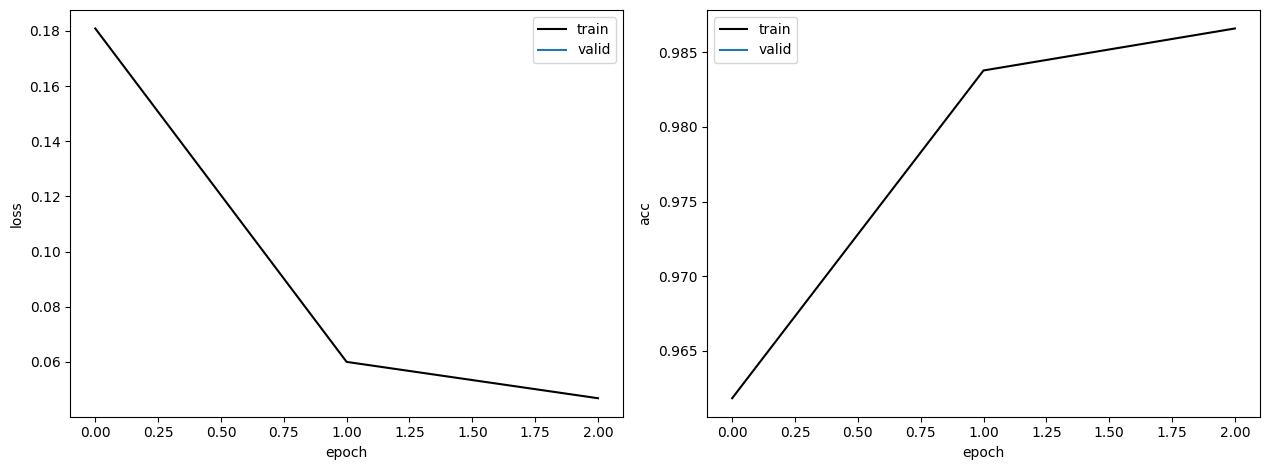

In [20]:
plot_losses(np.array([loss, acc]), np.array([[],[]]), 'loss', 'acc')

## Test

In [15]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    if wandb.run is not None:
        wandb.watch(model)
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    if wandb.run is not None:
        wandb.log({'n_way': n_way, 'k_shot': n_support})
        wandb.log({'Test loss': round(avg_loss, 4), 'Test acc': round(avg_acc, 4), 'n_way': n_way, 'k_shot': n_support})
    return [avg_loss, avg_acc]

In [30]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
    device='cuda'
)
model.load_state_dict(torch.load('./new_model.pt'))

<All keys matched successfully>

5-way 1-shot

In [19]:
print('test: 5-way 1-shot')
output = test(model, test_x, test_y, 5, 1, n_query, test_episode)
print(f'loss: {output[0]}, acc: {output[1]}')

test: 5-way 1-shot


  0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.05637213498512756, acc: 0.9818400000000015


5-way 5-shot

In [20]:
print('test: 5-way 5-shot')
output = test(model, test_x, test_y, n_way, n_support, n_query, test_episode)
print(f'loss: {output[0]}, acc: {output[1]}')

test: 5-way 5-shot


  0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.014282553361156716, acc: 0.9962400000000008


20-way 1-shot

In [21]:
print('test: 20-way 1-shot')
output = test(model, test_x, test_y, 20, 1, n_query, test_episode)
print(f'loss: {output[0]}, acc: {output[1]}')

test: 20-way 1-shot


  0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.17894091346673668, acc: 0.9470500000000077


20-way 5-shot

In [22]:
print('test: 20-way 5-shot')
output = test(model, test_x, test_y, 20, 5, n_query, test_episode)
print(f'loss: {output[0]}, acc: {output[1]}')

test: 20-way 5-shot


  0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.05133642854448408, acc: 0.9865400000000077


### Победить бейзлайны не получилось. Если пообучать модель на первоначальных параметрах, то скорее всего побить бейзлайн получится(требуется более 7 часов обучения)

In [27]:
wandb.finish()

Acc,▁█
Epoch,▁█
Loss,█▁
Test acc,█▆▁▇
Test loss,▁▃█▃
k_shot,██▁▁▁▁██
n_way,▁▁▁▁████
Acc,0.9869
Epoch,2
Loss,0.0508
Test acc,0.9839


## Test on specific example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['./images_evaluation/Tibetan/character21_rotated_90'
 './images_evaluation/Syriac_(Serto)/character06_rotated_270'
 './images_evaluation/Glagolitic/character18_rotated_90'
 './images_evaluation/Glagolitic/character02_rotated_90'
 './images_evaluation/Glagolitic/character22'
 './images_evaluation/Glagolitic/character03'
 './images_evaluation/Manipuri/character39_rotated_90'
 './images_evaluation/Glagolitic/character34_rotated_180'
 './images_evaluation/Syriac_(Serto)/character05_rotated_270'
 './images_evaluation/Sylheti/character18']


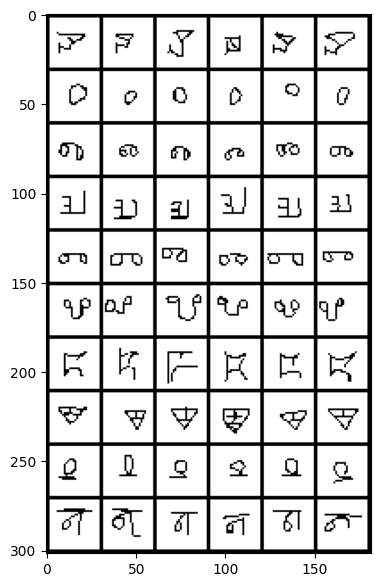

In [32]:
test_sample = extract_sample(10, 5, 1, test_x, test_y)
display_sample(test_sample['images'])
print(test_sample['targets'])

In [65]:
def predict(model, sample):
    with torch.inference_mode():
        output = model.set_forward_loss(sample)[1]['y_hat'].to('cpu').detach().numpy()
        preds = sample['targets'][output]
        print('predict : target')
        for pred, target in zip(preds, sample['targets']):
            print(f'{pred[0]} : {target}')

In [66]:
predict(model, test_sample)

predict : target
./images_evaluation/Tibetan/character21_rotated_90 : ./images_evaluation/Tibetan/character21_rotated_90
./images_evaluation/Syriac_(Serto)/character06_rotated_270 : ./images_evaluation/Syriac_(Serto)/character06_rotated_270
./images_evaluation/Glagolitic/character18_rotated_90 : ./images_evaluation/Glagolitic/character18_rotated_90
./images_evaluation/Glagolitic/character02_rotated_90 : ./images_evaluation/Glagolitic/character02_rotated_90
./images_evaluation/Glagolitic/character22 : ./images_evaluation/Glagolitic/character22
./images_evaluation/Glagolitic/character03 : ./images_evaluation/Glagolitic/character03
./images_evaluation/Manipuri/character39_rotated_90 : ./images_evaluation/Manipuri/character39_rotated_90
./images_evaluation/Glagolitic/character34_rotated_180 : ./images_evaluation/Glagolitic/character34_rotated_180
./images_evaluation/Syriac_(Serto)/character05_rotated_270 : ./images_evaluation/Syriac_(Serto)/character05_rotated_270
./images_evaluation/Sylhe

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


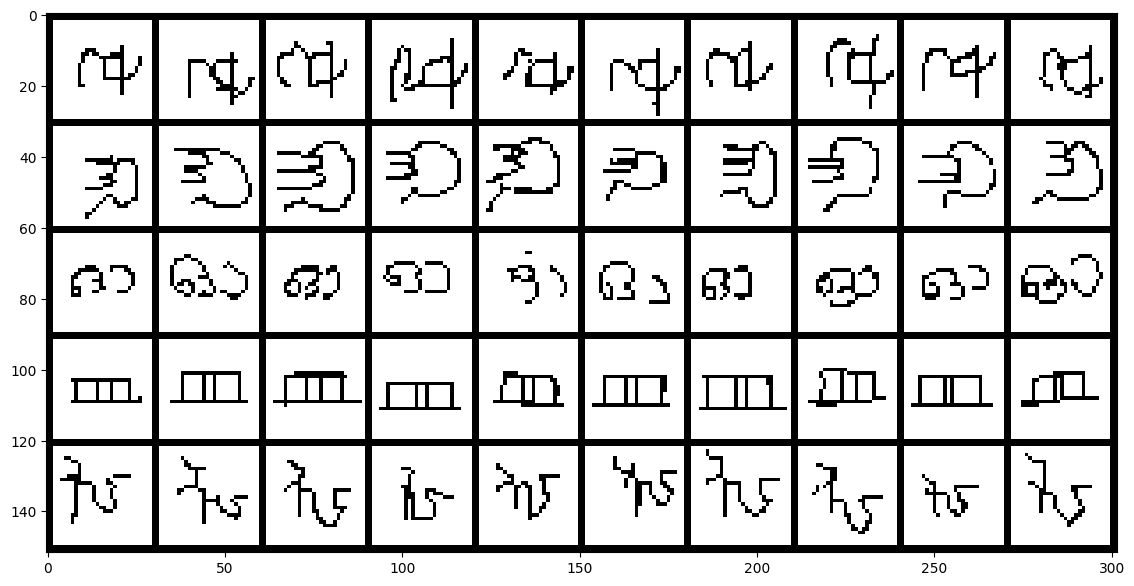

In [23]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [30]:
from sklearn.manifold import TSNE


def show_predictions(sample, encoder):
    sample_images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    sample_images = sample_images.to(next(encoder.parameters()).device)
    sample_images = sample_images.view(n_way * (n_support + n_query), *sample_images.shape[-3:])

    # img2vec results
    vectors = encoder(sample_images).view(n_way, (n_support + n_query), -1)
    vectors = vectors.to('cpu')
    # центры тяжести класстеров классов
    prototypes = vectors[:, :n_support].mean(1)
    prototypes = prototypes.cpu().detach().numpy()
    
    queries = vectors[:, n_support:].cpu().detach().numpy()
    
    prototypes = np.expand_dims(prototypes, axis=1)
    
    feats = np.concatenate([prototypes, queries], axis=1)
    feats = feats.reshape(-1, vectors.shape[-1])

    print('Train TSNE ... ')
    tsne = TSNE(n_components=2, perplexity=5, n_jobs=4)
    x_feats = tsne.fit_transform(feats)
    
    print('Plot labels ...')

    fig = plt.figure(figsize=(10, 8))

    colors = []

    for i in range(n_way):
        color = plt.cm.tab10(i / float(n_way))
        plt.scatter(x_feats[(n_query + 1) * i, 0], x_feats[(n_query + 1) * i, 1], marker='*', color=color)
        colors.append(color)
        
    for i in range(n_way):
        plt.scatter(x_feats[(n_query + 1) * i + 1:(n_query + 1) * (i + 1), 0], x_feats[(n_query + 1) * i + 1: (n_query + 1) * (i + 1), 1], color=colors[i])

        
    plt.legend([str(i) for i in range(n_way)])
    plt.grid(True)
    plt.tight_layout()
    plt.close()
    return fig

Train TSNE ... 
Plot labels ...


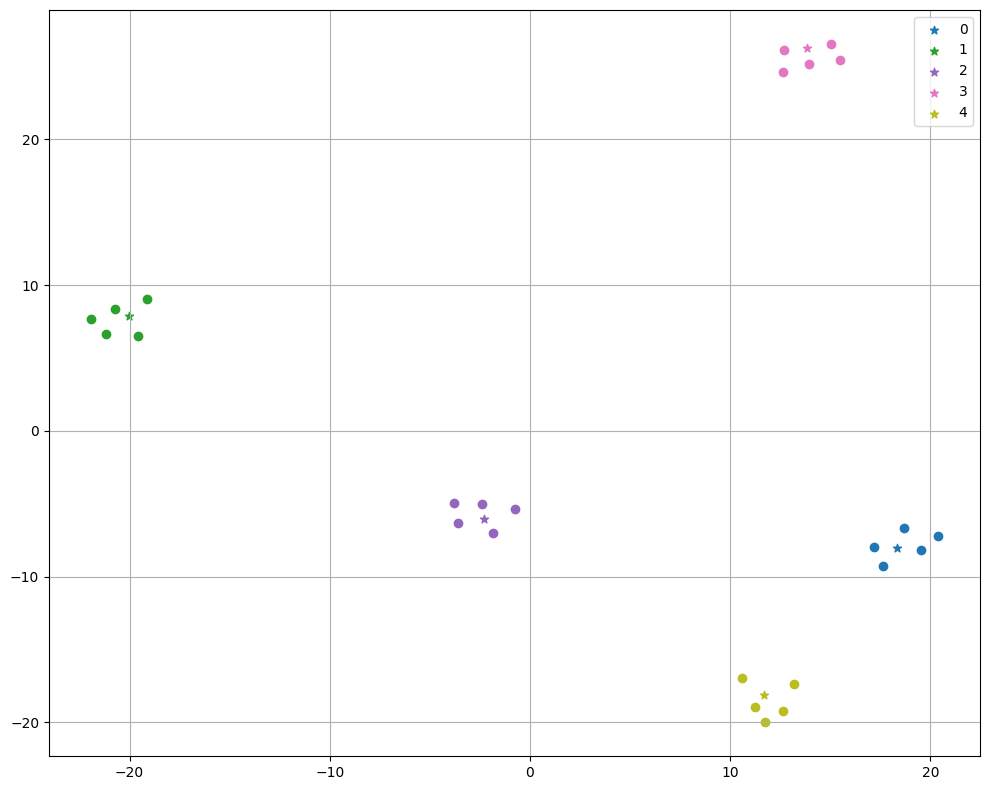

In [31]:
show_predictions(my_sample, model.encoder)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import albumentations as A
import yaml
import random
from albumentations.pytorch import ToTensorV2
from for_task6.cifar import load_cifar10
from PIL import Image

from for_task6.SimCLR_train_class import SimCLRTrainProcess
from for_task6.show_train_res import plot_losses

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data", channels_last=True)
X_test_train, X_test_val, y_test_train, y_test_val = train_test_split(X_test, y_test, test_size=0.3)

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])


In [4]:
MEAN = tuple(np.mean(X_train, axis=(0, 1, 2), keepdims=True, dtype=float).squeeze())
STD = tuple(np.std(X_train, axis=(0, 1, 2), keepdims=True, dtype=float).squeeze())

train_transform = A.Compose([
    A.OneOf([
        A.ColorJitter(),
        A.ToGray(),
#         A.GaussNoise(),
    ]),
#     A.OneOf([
#         A.Cutout(num_holes=1, max_h_size=10, max_w_size=10),
#         A.RandomResizedCrop(32, 32),
#         A.GaussianBlur(),
#     ]),
    A.HorizontalFlip(),
#     A.RandomRotate90(),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

## Обучаем предобученный энкодер на CIFAR10

In [5]:
with open('./for_task6/hyp_params.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

set_seed(hyps['seed'])

trainer = SimCLRTrainProcess(hyps)
trainer.device = 'cuda'
trainer.init_params(X_train, y_train, X_val, y_val, train_transform, valid_transform)

Train size: 40000 Valid size: 10000


C:\Users\Admin\anaconda3\envs\ldw\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\ldw\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_losses, valid_losses = trainer.run()

Valid 33/49, Loss: 3.594: 100%|████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.77it/s]


Valid 49/49, Loss: 3.591: 100%|████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 17.08it/s]


## Забираем "обученный" энкодер и обучаем на базе него классификатор

In [7]:
from for_task6.cifar_classifier_train_class import CIFARClassifierTrainProcess

In [8]:
with open('./for_task6/hyp_params_classifier.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

set_seed(hyps['seed'])

new_trainer = CIFARClassifierTrainProcess(hyps, trainer.model.encoder, trainer.model.emb_size)
new_trainer.device = 'cuda'
new_trainer.init_params(X_test_train, y_test_train, X_test_val, y_test_val, valid_transform, valid_transform)

Train size: 7000 Valid size: 3000


Valid 4/4, F1: 0.374, Loss: 1.701: 100%|███████████████████████████████████████████████| 23/23 [00:00<00:00, 31.50it/s]


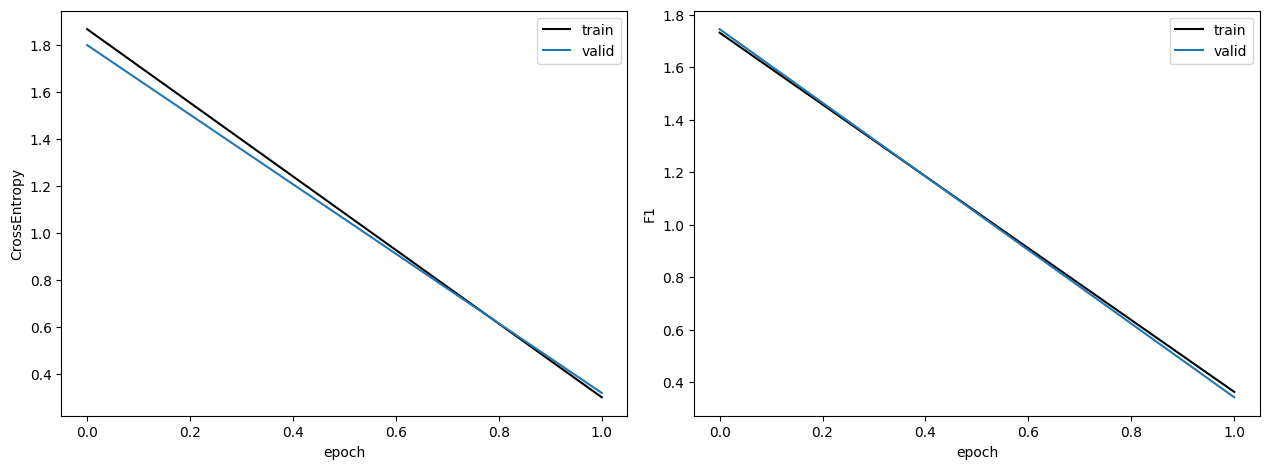

In [9]:
new_train_losses, new_valid_losses = new_trainer.run()
plot_losses(np.array(new_train_losses), np.array(new_valid_losses), 'CrossEntropy', 'F1')

## Для сравнения возьмем тот де предобученный энекодер и без доп обучения сразу на базе него обучим классификатор

In [10]:
from for_task6.model import PreModel
m = PreModel()

with open('./for_task6/hyp_params_classifier.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

set_seed(hyps['seed'])

new_trainer_with_simple_encoder = CIFARClassifierTrainProcess(hyps, m.encoder, m.emb_size)
new_trainer_with_simple_encoder.device = 'cuda'
new_trainer_with_simple_encoder.init_params(X_test_train, y_test_train, X_test_val, y_test_val, valid_transform, valid_transform)

C:\Users\Admin\anaconda3\envs\ldw\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\ldw\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train size: 7000 Valid size: 3000


Valid 4/4, F1: 0.442, Loss: 1.633: 100%|███████████████████████████████████████████████| 23/23 [00:00<00:00, 30.95it/s]


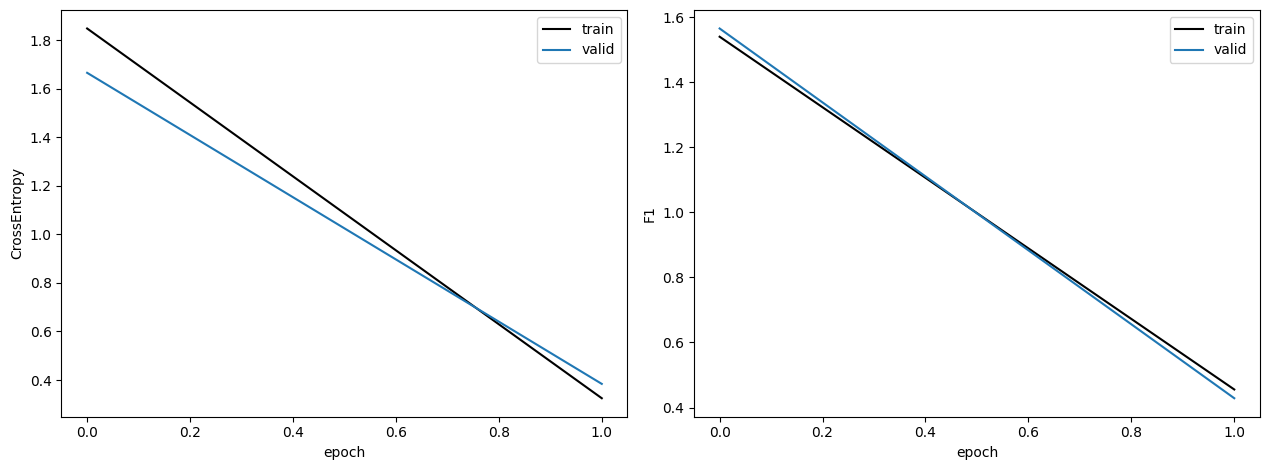

In [11]:
new_train_losses_simple_encoder, new_valid_losses_simple_encoder = new_trainer_with_simple_encoder.run()
plot_losses(np.array(new_train_losses_simple_encoder), np.array(new_valid_losses_simple_encoder), 'CrossEntropy', 'F1')

### Второй вариант показал себя лучше. Скорее всего дело в недостаточном обучении предобученного энкодера